In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from datetime import date

from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import importlib
import scripts.Strategy as ss

%load_ext autoreload
%autoreload 2
#importlib.reload(ss) #above magic works so won't need to manual reload

In [95]:
#data prepare
start=date(1990, 1, 1)
end=date(2020, 11, 16)

stock_list=['ICE', 'WLTW']
stock_pair=yf.download(stock_list, start, end, progress = False)

stock_pair=stock_pair[['Adj Close']].copy()
stock_pair.dropna(how='any', axis=0, inplace=True)
stock_pair.columns=stock_pair.columns.droplevel()
stock_pair.index=pd.DatetimeIndex(stock_pair.index)
#stock_pair.head()
dog_leash=stock_pair.copy()
smoothing='yes'
if smoothing=='yes':
        dog_leash=dog_leash.rolling(window=5).mean()
        dog_leash.dropna(inplace=True)
c=np.polyfit(dog_leash.iloc[:, 0], dog_leash.iloc[:, 1], 1)
dog_leash['Dog_leash']=dog_leash.iloc[:, 1]-c[0]*dog_leash.iloc[:, 0]
dog_leash=dog_leash[['Dog_leash']]
test_data=pd.merge(stock_pair, dog_leash, how='outer', on='Date')
test_data.dropna(how='any', axis=0, inplace=True)
test_data=test_data.reset_index()
test_data['realcombo']=-test_data.iloc[:,1]*c[0]+test_data.iloc[:,2]

In [96]:
test_data.head()

,Date,ICE,WLTW,Dog_leash,realcombo
0,2005-11-22,6.342704,69.851379,58.752772,59.340512
1,2005-11-23,6.161225,69.651382,59.311547,59.441256
2,2005-11-25,6.197519,69.724091,59.515885,59.453819
3,2005-11-28,6.043263,68.378700,59.294517,58.364055
4,2005-11-29,5.801895,67.324211,58.861839,57.709551


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


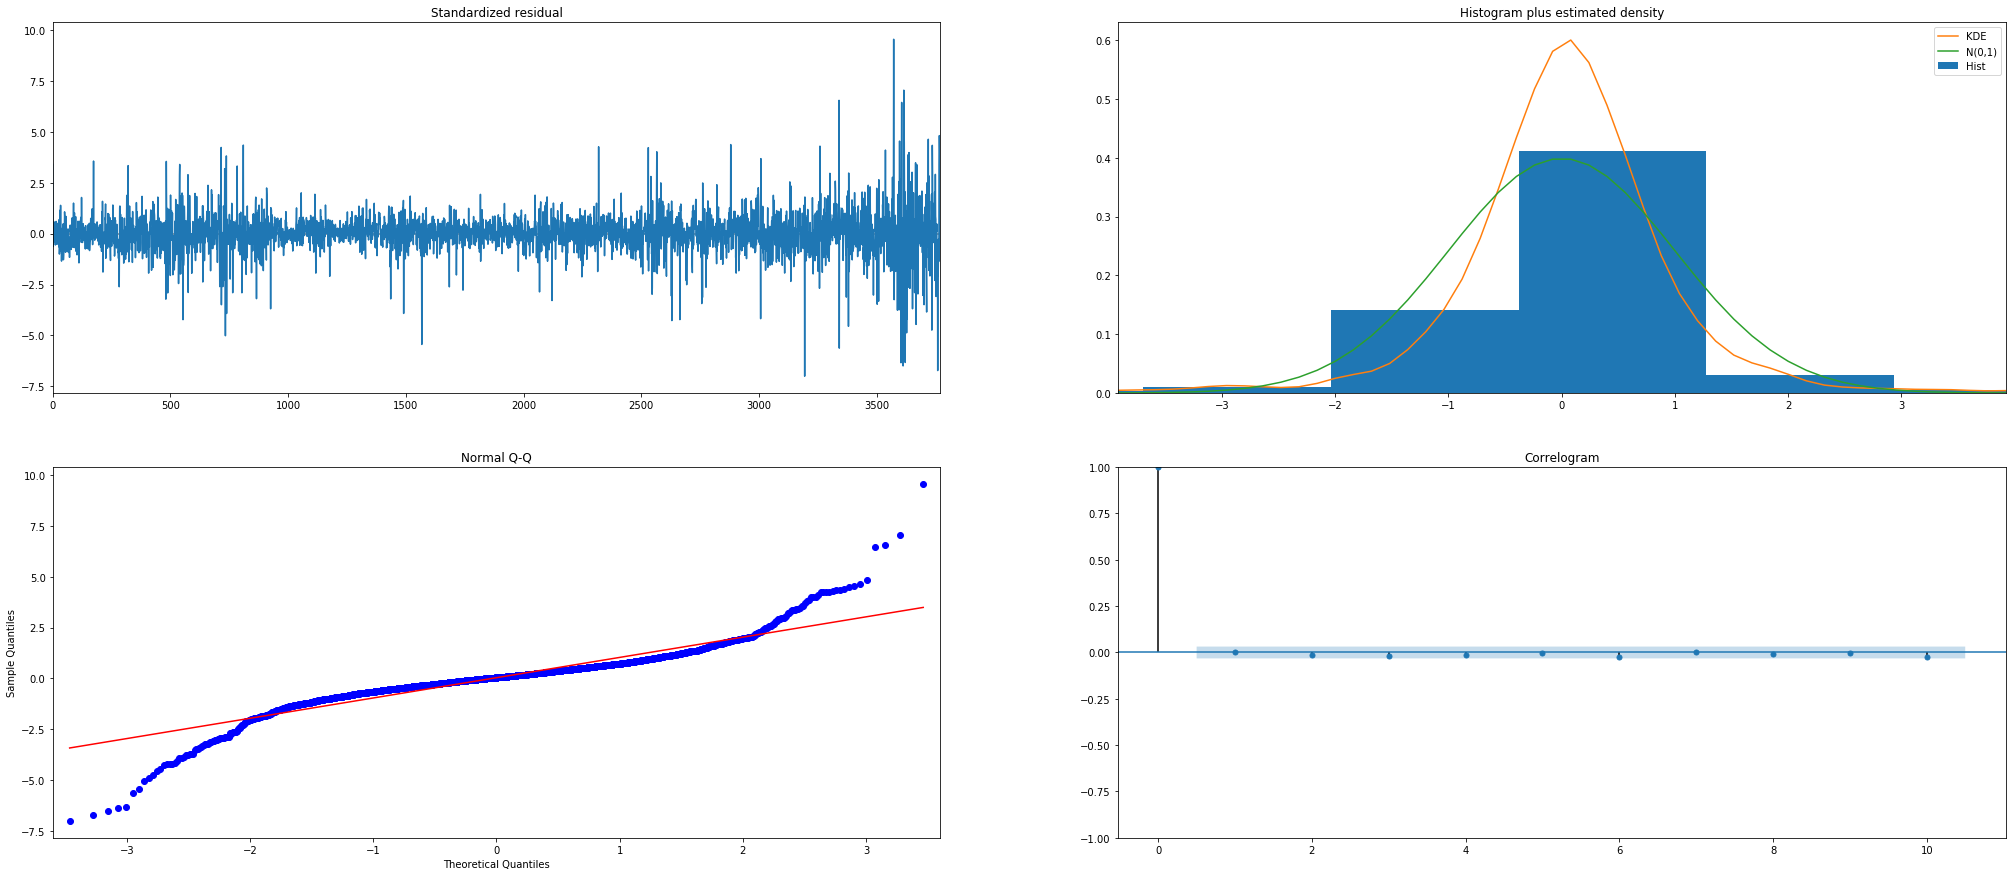

In [110]:
#build model
selected='Dog_leash'
model=SARIMAX(test_data[selected], order=(7, 0, 5))
results=model.fit()
#print(results.summary())
results.plot_diagnostics(figsize=(35,15))
plt.show()

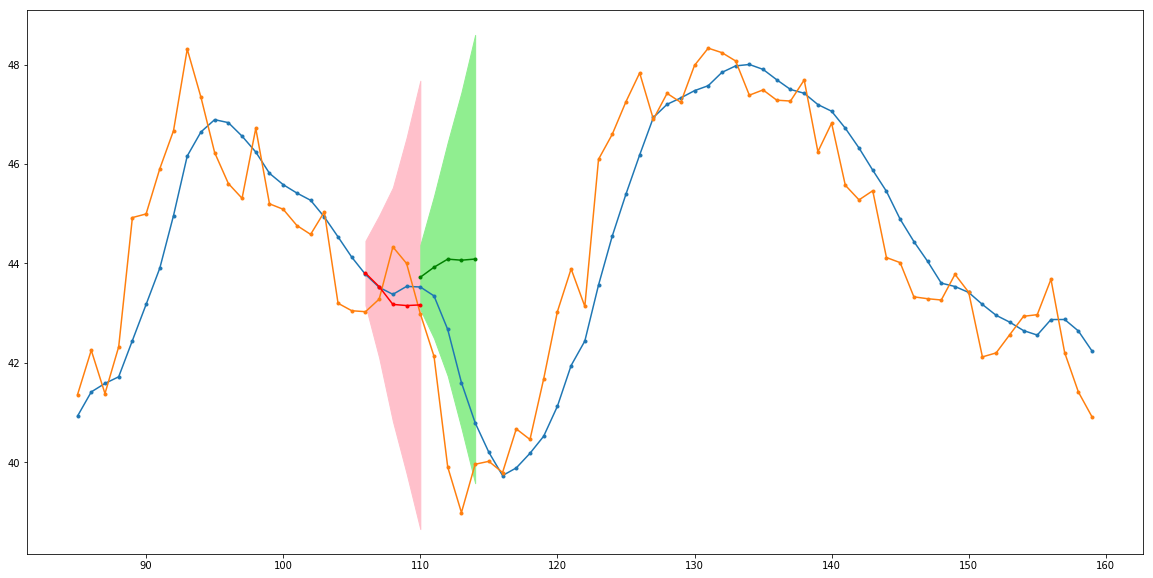

110
-0.013375878375569528
0.2023514481671569
0.3854558085094695


In [113]:
#test 4 points
test_start=-3700-71+110
back_forecast=results.get_prediction(start=test_start-4, end=test_start, dynamic=True)
for_forecast=results.get_prediction(start=test_start, end=test_start+4, dynamic=True)
mean_forecast=back_forecast.predicted_mean
mean_predict=for_forecast.predicted_mean

conf_intervals=back_forecast.conf_int()
for_intervals=for_forecast.conf_int()
#conf_intervals.head()
plt.figure(figsize=(20,10))
test_data.Dog_leash[test_start-25:test_start+50].plot(marker='.')
test_data.realcombo[test_start-25:test_start+50].plot(marker='.')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', marker='.', label='forecast')
plt.plot(mean_predict.index, mean_predict.values, color='green', marker='.', label='prediction')

plt.fill_between(conf_intervals.index, conf_intervals[f'lower {selected}'], conf_intervals[f'upper {selected}'], color='pink')
plt.fill_between(for_intervals.index, for_intervals[f'lower {selected}'], for_intervals[f'upper {selected}'], color='lightgreen')
plt.show()
print(len(test_data.index)+test_start)
first_var=test_data.iloc[len(test_data.index)+test_start-3,3]-mean_forecast[len(test_data.index)+test_start-3]
second_var=test_data.iloc[len(test_data.index)+test_start-2,3]-mean_forecast[len(test_data.index)+test_start-2]
third_var=test_data.iloc[len(test_data.index)+test_start-1,3]-mean_forecast[len(test_data.index)+test_start-1]
print(first_var)
print(second_var)
print(third_var)

In [87]:
print(test_start)
print(test_data.iloc[-3659])

-3659
Date         2006-05-05 00:00:00
ICE                      13.4676
WLTW                     62.2231
Dog_leash                42.6715
Name: 112, dtype: object


In [75]:
for i in range(112,122):
    r,p=ss.getPredictionAndRealData(results,test_data,i,3)
    prevTrend=ss.trendHelper(r)
    print(f"{i} prev real trend {prevTrend}  next trend: {ss.trendPredictor(prevTrend,r,p)}")

112 prev real trend -  next trend: (False, 'DOWN')
113 prev real trend -  next trend: (False, 'DOWN')
114 prev real trend DOWN  next trend: (True, 'DOWN')
115 prev real trend DOWN  next trend: (False, '-')
116 prev real trend DOWN  next trend: (False, '-')
117 prev real trend DOWN  next trend: (False, '-')
118 prev real trend -  next trend: (True, '-')
119 prev real trend UP  next trend: (False, '-')
120 prev real trend UP  next trend: (True, 'UP')
121 prev real trend UP  next trend: (True, 'UP')


In [91]:
#-3659
#Date         2006-05-05 00:00:00
#ICE                      13.4676
#WLTW                     62.2231
#Dog_leash                42.6715
start_point=-3659
print(f'{test_data.iloc[start_point]}')
print(f'{test_data.iloc[start_point,2]}')
print(f'{test_data.iloc[start_point,1]}')
print(13.4676*1.65715858998607-62.2231)
position0=test_data.iloc[start_point, 2]-c[0]*test_data.iloc[start_point, 1]
print(position0)
position0=c[0]*test_data.iloc[start_point, 1]-test_data.iloc[start_point, 2]
print(position0)

Date         2006-05-05 00:00:00
ICE                      13.4676
WLTW                     62.2231
Dog_leash                42.6715
Name: 112, dtype: object
62.223106384277344
13.4675874710083
-39.90515097350361
39.9051781203071
-39.9051781203071


In [107]:
profit=0

traiding_start=-len(test_data)
ending=len(test_data)
#test_start=-100
main_list=[]
temp_list=[]
current_position='-'
openOptionTrend=''
    
for i in range(110,ending):
    start_point=i
    real,prediction=ss.getPredictionAndRealData(results,test_data,start_point)
    #current_trend=trendHelper(real)
    #t,next_trend=trendPredictor(current_trend,[],prediction)
    action, buyOrShort=ss.positionStrategy(current_position,openOptionTrend,real,prediction)
    #print(f'idx {i} position strategy:  {action} {buyOrShort} current position {current_position}')
    #print(f'current index {start_point}, current_trend {current_trend},next_trend is {next_trend},current position {current_position} action:{action}')
    
    if(action=='C'):
        #FIRST NEED TO LOSE AND THEN ENTER NEW POSITION
        lastest_position=main_list[-1]
        prev_price=lastest_position[3]
        prev_strategy=lastest_position[-1]
        if(prev_strategy=='L'):
            position0=test_data.iloc[start_point, 2]-c[0]*test_data.iloc[start_point, 1]
            profit=profit+(position0-prev_price)
        if(prev_strategy=='S'):
            position0=c[0]*test_data.iloc[start_point, 1]-test_data.iloc[start_point, 2]
            profit=profit+(position0-prev_price)
        print(f'idx {lastest_position[0]} to idx {start_point}. prev_price {prev_price}, curr price {position0} profit is {position0-prev_price} stragegy:{prev_strategy}')
    if(buyOrShort=='L'):
            position0=test_data.iloc[start_point, 2]-c[0]*test_data.iloc[start_point, 1]
            temp_list=[start_point, -test_data.iloc[start_point, 1], test_data.iloc[start_point, 2], position0, c[0], 'O',buyOrShort]
            main_list.append(temp_list)
            openOptionTrend='UP'
            current_position='O'
    if(buyOrShort=='S'):
            position0=c[0]*test_data.iloc[start_point, 1]-test_data.iloc[start_point, 2]
            temp_list=[start_point, test_data.iloc[start_point, 1], -test_data.iloc[start_point, 2], position0, c[0], 'O',buyOrShort]
            main_list.append(temp_list)
            openOptionTrend='DOWN'
            current_position='O'
 
            
          
    

idx 175 to idx 284. prev_price -49.361257810226356, curr price -32.22211752064294 profit is 17.139140289583416 stragegy:S
idx 284 to idx 290. prev_price 32.22211752064294, curr price 39.418237960822744 profit is 7.196120440179804 stragegy:L
idx 290 to idx 518. prev_price -39.418237960822744, curr price -15.66473699639343 profit is 23.753500964429314 stragegy:S
idx 518 to idx 524. prev_price 15.66473699639343, curr price 16.432271167495095 profit is 0.7675341711016657 stragegy:L
idx 524 to idx 525. prev_price -16.432271167495095, curr price -15.05381805322395 profit is 1.3784531142711458 stragegy:S
idx 525 to idx 531. prev_price 15.05381805322395, curr price 18.624351818352615 profit is 3.5705337651286655 stragegy:L
idx 531 to idx 536. prev_price -18.624351818352615, curr price -20.001920740447716 profit is -1.3775689220951008 stragegy:S
idx 536 to idx 539. prev_price 20.001920740447716, curr price 25.702484633605486 profit is 5.700563893157771 stragegy:L
idx 539 to idx 812. prev_price 

In [108]:
profit

31.20245958481547

In [76]:
test_results=pd.DataFrame(main_list, columns=('day_index', 'low_pos', 'high_pos', 'p_l', 'coef', 'Trade_type','L/S'))
test_results.to_csv('./data/mymainlistreulst.csv')